<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import" data-toc-modified-id="Import-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import</a></span></li><li><span><a href="#To-load-the-data" data-toc-modified-id="To-load-the-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>To load the data</a></span></li><li><span><a href="#Load-the-strong-annotation-and-the-ground-thruth" data-toc-modified-id="Load-the-strong-annotation-and-the-ground-thruth-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load the strong annotation and the ground thruth</a></span></li><li><span><a href="#Prune-using-ground-truth-(ORACLE)" data-toc-modified-id="Prune-using-ground-truth-(ORACLE)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Prune using ground truth (ORACLE)</a></span></li><li><span><a href="#Display-function" data-toc-modified-id="Display-function-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Display function</a></span></li><li><span><a href="#Manual" data-toc-modified-id="Manual-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Manual</a></span></li><li><span><a href="#Data-driven" data-toc-modified-id="Data-driven-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Data driven</a></span><ul class="toc-item"><li><span><a href="#mean-threshold" data-toc-modified-id="mean-threshold-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>mean threshold</a></span></li><li><span><a href="#global-mean-threshold" data-toc-modified-id="global-mean-threshold-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>global mean threshold</a></span></li><li><span><a href="#global-mean-threshold-global" data-toc-modified-id="global-mean-threshold-global-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>global mean threshold global</a></span></li><li><span><a href="#median-threshold" data-toc-modified-id="median-threshold-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>median threshold</a></span></li><li><span><a href="#global-median-threshold" data-toc-modified-id="global-median-threshold-7.5"><span class="toc-item-num">7.5&nbsp;&nbsp;</span>global median threshold</a></span></li></ul></li><li><span><a href="#Parametric" data-toc-modified-id="Parametric-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Parametric</a></span><ul class="toc-item"><li><span><a href="#Absolute-Threshold" data-toc-modified-id="Absolute-Threshold-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Absolute Threshold</a></span></li><li><span><a href="#Hysteresis" data-toc-modified-id="Hysteresis-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Hysteresis</a></span></li><li><span><a href="#Derivative" data-toc-modified-id="Derivative-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>Derivative</a></span></li></ul></li></ul></div>

# Import

In [22]:
!pip uninstall sed_tool -y

Uninstalling sed-tool-0.0.4:
  Successfully uninstalled sed-tool-0.0.4


In [38]:
%load_ext autoreload
%autoreload 2

import numpy as np
import time
import os
import pickle
import matplotlib.pyplot as plt
import dcase_util as dcu

from sed_tool.Encoder import Encoder
from sed_tool.optimizers import GenOptimizer, DichotomicOptimizer
from sed_tool.sed_tools import eb_evaluator

import numpy as np

import matplotlib.pyplot as plt

# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot
jtplot.style(theme="onedork", context="notebook", grid=True)
jtplot.base_context["grid.linewidth"] = 0.2

import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
from bokeh.plotting import figure, show
from bokeh.layouts import column
from bokeh.models import LinearColorMapper, ColumnDataSource
from bokeh.palettes import Spectral11, cividis, Category20_20, Category10
from bokeh.io import output_notebook, push_notebook
from bokeh.io import output_file, show
from bokeh.io import curdoc
from bokeh.io import export_png
from bokeh.layouts import widgetbox
from bokeh.models.widgets import CheckboxButtonGroup, Paragraph

output_notebook()

Loading BokehJS ...

In [40]:
Category10

{3: ['#1f77b4', '#ff7f0e', '#2ca02c'],
 4: ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'],
 5: ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'],
 6: ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'],
 7: ['#1f77b4',
  '#ff7f0e',
  '#2ca02c',
  '#d62728',
  '#9467bd',
  '#8c564b',
  '#e377c2'],
 8: ['#1f77b4',
  '#ff7f0e',
  '#2ca02c',
  '#d62728',
  '#9467bd',
  '#8c564b',
  '#e377c2',
  '#7f7f7f'],
 9: ['#1f77b4',
  '#ff7f0e',
  '#2ca02c',
  '#d62728',
  '#9467bd',
  '#8c564b',
  '#e377c2',
  '#7f7f7f',
  '#bcbd22'],
 10: ['#1f77b4',
  '#ff7f0e',
  '#2ca02c',
  '#d62728',
  '#9467bd',
  '#8c564b',
  '#e377c2',
  '#7f7f7f',
  '#bcbd22',
  '#17becf']}

# To load the data

In [7]:
import numpy as np
import os

class_correspondance = {"Alarm_bell_ringing": 0, "Speech": 1, "Dog": 2, "Cat": 3, "Vacuum_cleaner": 4,
                        "Dishes": 5, "Frying": 6, "Electric_shaver_toothbrush": 7, "Blender": 8, "Running_water": 9}
class_correspondance_reverse = dict(zip(
    list(class_correspondance.values()),
    list(class_correspondance.keys()))
)


def load_test_mil():
    filenames = np.load(os.path.join("data", "metadata", "X_test_fn.npy"), allow_pickle=True)
    strong_prediction = np.load(os.path.join("data", "strong_prediction", "mil_cos_test.npy"), allow_pickle=True)
    
    return strong_prediction, filenames

def load_eval_mil():
    filenames = np.load(os.path.join("data", "metadata", "X_eval_fn.npy"), allow_pickle=True)
    strong_prediction = np.load(os.path.join("data", "strong_prediction", "mil_cos_eval.npy"), allow_pickle=True)
    
    return strong_prediction, filenames

def load_test_baseline():
    filenames = np.load(os.path.join("data", "metadata", "X_test_fn.npy"), allow_pickle=True)
    strong_prediction = np.load(os.path.join("data","strong_prediction", "baseline_test.npy"), allow_pickle=True)

    return strong_prediction, filenames

def load_eval_baseline():
    filenames = np.load(os.path.join("data", "metadata", "X_eval_fn.npy"), allow_pickle=True)
    strong_prediction = np.load(os.path.join("data","strong_prediction", "baseline_eval.npy"), allow_pickle=True)

    return strong_prediction, filenames

def load_mil_at_test():
    data = np.load(os.path.join("data", "weak_prediction", "mil_at_test.pkl"), allow_pickle=True)
    weak_prediction = data["all_test_preds"]
    filenames = data["featTestList"]
    
    return weak_prediction, filenames
    
def load_mil_at_eval():
    data = np.load(os.path.join("data", "weak_prediction", "mil_at_eval.pkl"), allow_pickle=True)
    weak_prediction = data["all_eval_preds"]
    filenames = data["featEvalList"]
    
    return weak_prediction, filenames

def load_baseline_at_test():
    filenames = np.load(os.path.join("data", "metadata", "X_test_fn.npy"), allow_pickle=True)
    weak_prediction = np.load(os.path.join("data", "weak_prediction", "baseline_at_test.npy"), allow_pickle=True)
    
    weak_prediction[weak_prediction > 0.5] = 1
    weak_prediction[weak_prediction <= 0.5] = 0
    
    return weak_prediction, filenames

def load_baseline_at_eval():
    filenames = np.load(os.path.join("data", "metadata", "X_eval_fn.npy"), allow_pickle=True)
    weak_prediction = np.load(os.path.join("data", "weak_prediction", "baseline_at_eval.npy"), allow_pickle=True)
    
    weak_prediction[weak_prediction > 0.5] = 1
    weak_prediction[weak_prediction <= 0.5] = 0
    
    return weak_prediction, filenames

def load_test_ground_truth():
    test_unique_names = np.load(os.path.join("data", "metadata", "X_test_fn.npy"))

    with open(os.path.join("data", "metadata", "test.csv"), "r") as f:
        test_metadata = f.read().splitlines()[1:]
    test_metadata = np.array([info.split("\t") for info in test_metadata])
    test_medata_filenames = np.unique(test_metadata[:, 0])

    y_test = []
    for name in test_medata_filenames:
        # remove  missing files
        if name not in test_unique_names:
            continue

        # create a tag level prediction (aka weak labels)
        output = [0] * 10

        for d in test_metadata:
            if d[0] == name:
                output[class_correspondance[d[-1]]] = 1
        y_test.append(output)
    y_test = np.array(y_test)

    return y_test, test_unique_names

def load_eval_ground_truth():
    eval_unique_names = np.load(os.path.join("data", "metadata", "X_eval_fn.npy"))

    with open(os.path.join("data", "metadata", "eval.csv"), "r") as f:
        eval_metadata = f.read().splitlines()[1:]
    eval_metadata = [info.split("\t") for info in eval_metadata]
    eval_medata_filenames = np.unique([i[0] for i in eval_metadata])

    y_eval = []
    for name in eval_medata_filenames:
        # remove  missing files
        if name not in eval_unique_names:
            continue

        # create a tag level prediction (aka weak labels)
        output = [0] * 10

        for d in eval_metadata:
            if d[0] == name:
                if len(d) == 4:
                    output[class_correspondance[d[-1]]] = 1
        y_eval.append(output)
    y_eval = np.array(y_eval)

    return y_eval, eval_unique_names

def load_test_strong_ground_truth():
    # test ground truth
    with open(os.path.join("data", "metadata", "test.csv"), "r") as f:
        strong_y_true = f.read().splitlines()[1:]
    return strong_y_true

def load_eval_strong_ground_truth():
    # test ground truth
    with open(os.path.join("data", "metadata", "eval.csv"), "r") as f:
        strong_y_true = f.read().splitlines()[1:]
    return strong_y_true

# Load the strong annotation and the ground thruth

In [8]:
test_strong_prediction, test_filenames = load_test_mil()
eval_strong_prediction, eval_filenames = load_eval_mil()
# test_strong_prediction, test_filenames = load_test_baseline()
# eval_strong_prediction, eval_filenames = load_eval_baseline()

# test & eval STRONG PREDICTION ground truth
test_strong_y_true = load_test_strong_ground_truth()
eval_strong_y_true = load_eval_strong_ground_truth()

# test & eval WEAK PREDICTION ground truth ORACLE
test_gt, test_gt_filenames = load_test_ground_truth()
eval_gt, eval_gt_filenames = load_eval_ground_truth()

# test & eval WEAK PREDICTION AT
test_at, test_at_filenames = load_mil_at_test()
eval_at, eval_at_filenames = load_mil_at_eval()
# test_at, test_at_filenames = load_baseline_at_test()
# eval_at, eval_at_filenames = load_baseline_at_eval()

In [11]:
test_strong_y_true

['Y00pbt6aJV8Y_350.000_360.000.wav\t0.0\t9.971\tVacuum_cleaner',
 'Y00pK0GMmE9s_70.000_80.000.wav\t0.0\t10.0\tVacuum_cleaner',
 'Y02sD1KJeoGA_50.000_60.000.wav\t0.0\t10.0\tFrying',
 'Y0a8RB5eOGJ4_30.000_40.000.wav\t0.28600000000000003\t0.725\tDog',
 'Y0a8RB5eOGJ4_30.000_40.000.wav\t2.094\t2.387\tDog',
 'Y0a8RB5eOGJ4_30.000_40.000.wav\t2.6430000000000002\t3.016\tDog',
 'Y0a8RB5eOGJ4_30.000_40.000.wav\t3.287\t3.66\tDog',
 'Y0a8RB5eOGJ4_30.000_40.000.wav\t3.946\t4.3919999999999995\tDog',
 'Y0a8RB5eOGJ4_30.000_40.000.wav\t4.671\t5.1610000000000005\tDog',
 'Y0a8RB5eOGJ4_30.000_40.000.wav\t7.621\t8.404\tDog',
 'Y0a8RB5eOGJ4_30.000_40.000.wav\t8.836\t9.202\tDog',
 'Y0a8RB5eOGJ4_30.000_40.000.wav\t9.458\t9.927\tDog',
 'Y0bjUq9XMMmQ_30.000_40.000.wav\t0.0\t10.0\tFrying',
 'Y0BnyrbZz8Jk_30.000_40.000.wav\t1.127\t2.6430000000000002\tDog',
 'Y0BnyrbZz8Jk_30.000_40.000.wav\t2.963\t4.744\tDog',
 'Y0BnyrbZz8Jk_30.000_40.000.wav\t6.069\t10.0\tDog',
 'Y0cGgIDhIfdA_30.000_40.000.wav\t3.2960000000000003\

In [44]:
def reorder(to_reorder_data, to_reorder_filenames):
    # create a dict where the key are the filenames and the values the pred
    to_reorder_tmp = dict(zip(to_reorder_filenames, to_reorder_data))
    
    # sort and create a list of tuple (key, pred)
    sort = sorted(to_reorder_tmp.items(), key=lambda kv: kv[0])
    filenames = np.asarray([t[0] for t in sort])
    data = np.asarray([t[1] for t in sort])
    
    return data, filenames

test_at, test_at_filenames = reorder(test_at, test_at_filenames)
eval_at, eval_at_filenames = reorder(eval_at, eval_at_filenames)

test_gt, test_gt_filenames = reorder(test_gt, test_gt_filenames)
eval_gt, eval_gt_filenames = reorder(eval_gt, eval_gt_filenames)

test_strong_prediction, test_filenames = reorder(test_strong_prediction, test_filenames)
eval_strong_prediction, eval_filenames = reorder(eval_strong_prediction, eval_filenames)


In [45]:
test_strong_prediction.mean(), test_strong_prediction.std(), test_strong_prediction.shape

(0.02918718, 0.09151293, (279, 431, 10))

(279, 10)


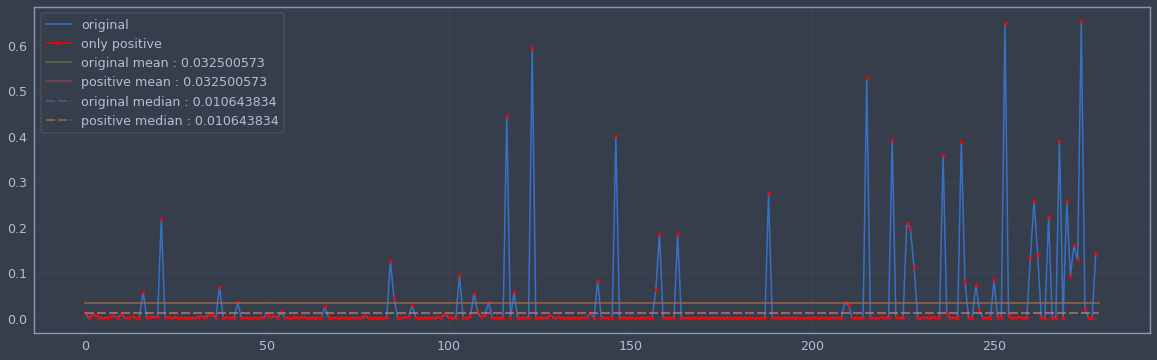

previous : 
[0.03250058 0.04318672 0.00977716 0.0072976  0.01828468 0.00328659
 0.03058764 0.0157005  0.02781211 0.10343817]
(10,)
new : 
[0.03250057 0.04318671 0.00977717 0.0072976  0.01828469 0.00328659
 0.03058764 0.01570049 0.02781212 0.10343817]
(10,)


In [46]:
total_thresholds = []
for clip in test_strong_prediction:
    total_thresholds.append([curve.mean() for curve in clip.T])

total_thresholds = np.array(total_thresholds)
print(total_thresholds.shape)
test = total_thresholds.T[0]

plt.figure(figsize=(20, 6))
plt.plot(test, color="C0", label="original")

count = 0
for i, x in enumerate(test):
    if x != 0:
        if count == 0:
            plt.plot([i], [x], marker=".", color="red", label="only positive")
        else:
            plt.plot([i], [x], marker=".", color="red")
        count += 1

        
orig_mean = test.mean()
new_mean = test[test > 0].mean()
orig_median = test[len(test) // 2]
new_median = test[test > 0][len(test[test > 0]) // 2]

plt.plot([0, 279], [orig_mean, orig_mean], color = "C1", alpha=0.5, label="original mean : %s" % orig_mean)
plt.plot([0, 279], [new_mean, new_mean], color = "C2", alpha=0.5, label="positive mean : %s" % new_mean)
plt.plot([0, 279], [orig_median, orig_median], color = "C3", alpha=0.5, dashes=[6, 2], label="original median : %s" % orig_median)
plt.plot([0, 279], [new_median, new_median], color = "C4", alpha=0.5, dashes=[6, 2], label="positive median : %s" % new_median)
plt.legend()
plt.show()

# removes all mean == 0
means = np.zeros(10)
for i, col in enumerate(total_thresholds.T):
    means[i] = col[col > 0].mean()

print("previous : ")
print(total_thresholds.mean(axis=0))
print(total_thresholds.mean(axis=0).shape)

print("new : ")
print(means)
print(means.shape)

# Prune using ground truth (ORACLE)

In [47]:
# Prune the result of fill the missing curve with 0 segments
def prune_prediction(strong_prediction, cls_prediction):
    """ Prune the strong prediciton by zeroing all classes that are not predicted. """
    pruned_prediction = strong_prediction.copy()
    
    for index in range(len(pruned_prediction)):
        cls_result = cls_prediction[index].copy()
        curves = pruned_prediction[index]

        for i in range(len(cls_result)):
            if cls_result[i] == 0:
                curves[:,i] = 0
                
    return pruned_prediction

In [48]:
# PRUNE USING GROUND TRUTH (AT ORACLE)
eval_strong_prediction = prune_prediction(eval_strong_prediction, eval_gt)
test_strong_prediction = prune_prediction(test_strong_prediction, test_gt)

# PRUNE USING MODEL AT
# eval_strong_prediction = prune_prediction(eval_strong_prediction, eval_at)
# test_strong_prediction = prune_prediction(test_strong_prediction, test_at)

In [49]:
test_strong_prediction.mean(), test_strong_prediction.std()

(0.014733395, 0.08150168)

# Display function

In [50]:
# monitor one metrics
def monitor_one(results, metric, sort: bool = False):
    out = []
    
    for k in results.keys():
        out.append((k, results[k]["class_wise_average"]["f_measure"][metric]))
        
    if sort:
        out = sorted(out, key=lambda x: x[1])
    
    return np.array(out)

def display_history(metric, hist_metric=None, bins=20):
    x, y = metric[:, 0], metric[:, 1]

    max_y = max(y)
    max_x = list(y).index(max_y)
    print(max_x, max_y)

    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.title("f_measure")
    plt.plot(range(len(y)), y, label="f1")
    plt.plot(max_x, max_y, "ro", label="f1:%.2f" % (max_y, ))

    plt.ylabel("f1")
    plt.xlabel("threshold")
    plt.xticks([0, len(x)], [0, len(x)])
    plt.legend()

    plt.subplot(1, 2, 2)
    
    if hist_metric is None:
        plt.hist(list(y), bins=bins)
    else:
        plt.hist(hist_metric, bins=bins)
    plt.show()
    
    return x[list(y).index(max_y)]

# Manual

In [51]:
# TEST
# Create the encoder that will be used
class_list = ['Alarm_bell_ringing', 'Speech', 'Dog', 'Cat', 'Vacuum_cleaner', 'Dishes', 'Frying', 'Electric_shaver_toothbrush', 'Blender', 'Running_water']

encoder = Encoder(
    classes=class_list,
    temporal_precision = 200,  # ms
    clip_length = 10,          # s
    minimal_segment_step = 200 # ms
)

segments = encoder.encode(
    eval_strong_prediction,
    method="threshold",
    threshold=0.35,
    smooth="smoothMovingAvg",
    window_len=17
)
to_evaluate = encoder.parse(segments, eval_filenames)

# segments = encoder.encode(
#     test_strong_prediction,
#     method="hysteresis",
#     low=0.02,
#     high=0.04,
#     smooth="smoothMovingAvg",
#     window_len=19
# )
# to_evaluate_hysteresis = encoder.parse(segments, test_filenames)

evaluator = eb_evaluator(eval_strong_y_true, to_evaluate)
print(evaluator)

Event based metrics (onset-offset)
  Evaluated length                  : 7543.56 sec
  Evaluated files                   : 880 
  Evaluate onset                    : True 
  Evaluate offset                   : True 
  T collar                          : 200.00 ms
  Offset (length)                   : 20.00 %

  Overall metrics (micro-average)
  F-measure
    F-measure (F1)                  : 13.87 %
    Precision                       : 19.71 %
    Recall                          : 10.70 %
  Error rate
    Error rate (ER)                 : 1.33 
    Substitution rate               : 0.00 
    Deletion rate                   : 0.89 
    Insertion rate                  : 0.43 

  Class-wise average metrics (macro-average)
  F-measure
    F-measure (F1)                  : 6.91 %
    Precision                       : 9.83 %
    Recall                          : 5.33 %
  Error rate
    Error rate (ER)                 : 1.33 
    Deletion rate                   : 0.95 
    Insertion rate    

In [52]:
def display_clip(strong_prediction, strong_y_true, atth, ath, filenames, index=0):
    x = np.linspace(0, 10, 431)
    y = test_strong_prediction[index].T
    
    p = figure(plot_width=1600, plot_height=500,
               y_range=(-0.4, 1),
               title=filenames[index] 
              )
    
    for i, curve in enumerate(y):
        # plot the curve
        if not curve.mean() == 0:
            p.line(x=x, y=curve, color=Category10[10][i], legend=class_correspondance_reverse[i])
            
    # plot the ground truth
    # select gt for this specific file
    clas = strong_y_true[:,-1][strong_y_true[:,0] == filenames[index]]
    rects = strong_y_true[:,1:-1][strong_y_true[:,0] == filenames[index]]

    for i in range(len(clas)):
        bottom = -0.1
        high = -0.02
        
        p.patch(
            x=[rects[i][0], rects[i][0], rects[i][1], rects[i][1]],
            y=[bottom,high, high, bottom],
            alpha=0.25,
            color=Category10[10][class_correspondance[clas[i]]]
        )
        
    # plot the segment calculated (threshold)
    clas_at = atth[:,-1][atth[:,0] == filenames[index]]
    rects_at = atth[:,1:-1][atth[:,0] == filenames[index]]
    
    for i in range(len(clas_at)):
        bottom = -0.2
        high = -0.12
        
        p.patch(
            x=[rects_at[i][0], rects_at[i][0], rects_at[i][1], rects_at[i][1]],
            y=[bottom,high, high, bottom],
            alpha=0.25,
            color=Category10[10][class_correspondance[clas_at[i]]]
        )
        
    # plot the segment calculated (hysteresis)
    clas_ath = ath[:,-1][ath[:,0] == filenames[index]]
    rects_ath = ath[:,1:-1][ath[:,0] == filenames[index]]
    
    for i in range(len(clas_ath)):
        bottom = -0.3
        high = -0.22
        
        p.patch(
            x=[rects_ath[i][0], rects_ath[i][0], rects_ath[i][1], rects_ath[i][1]],
            y=[bottom,high, high, bottom],
            alpha=0.25,
            color=Category10[10][class_correspondance[clas_ath[i]]]
        )
    
    path = os.path.join("data", "img_segments", filenames[index] + ".png")
    export_png(p, filename=path)
#     show(p)

In [53]:
rects = tytgt[:,1:][tytgt[:,0] == tytgt_filenames[3]]
rects

NameError: name 'tytgt' is not defined

In [ ]:
# ground_truth
tytgt = np.asarray([t.split("\t") for t in test_strong_y_true])
tytgt_filenames = np.unique(tytgt[:,0])

# manually encoded threshold
tatth = to_evaluate_threshold[:-1].split("\n")
tatth = np.asarray([t.split("\t") for t in tatth])


# manually encoded hysteresis
tath = to_evaluate_hysteresis[:-1].split("\n")
tath = np.asarray([t.split("\t") for t in tath])


for i in tqdm.tqdm_notebook(range(0, 250)):
    display_clip(test_strong_prediction, tytgt, tatth, tath, tytgt_filenames, index=i)

**interesting**
- Y0eNfQDAbn_Y_20.000_30.000.wav.png
- Y0lUFEAnnET8_30.000_40.000.wav


# Data driven
 **baseline**
 
|         .               |  test |  .   |  eval |  .   |
|--------------------     | ----- |------| ----- |------|
|         .               |   f1  |  er  |   f1  |  er  |
| mean threshold          |  2.45 | 3.00 |  3.53 | 3.12 |
| global mean threhsold   | 19.87 | 1.30 | 17.87 | 1.46 |
| median threshold        |  3.28 | 3.38 |  3.02 | 3.51 |
| global median threshold | 19.53 | 1.32 | 17.74 | 1.46 |

**mil**

|         .               |  test |  .   |  eval |  .   |
|--------------------     | ----- |------| ----- |------|
|         .               |   f1  |  er  |   f1  |  er  |
| mean threshold          | 12.90 | 6.12 | 10.21 | 6.11 |
| global mean threhsold   | 28.96 | 1.34 | 25.45 | 1.51 |
| median threshold        |  7.97 | 5.39 |  7.50 | 4.83 |
| global median threshold | 29.00 | 1.30 | 25.36 | 1.52 |

**cos mil**

|         .               |  test |  .   |  eval |  .   |
|--------------------     | ----- |------| ----- |------|
|         .               |   f1  |  er  |   f1  |  er  |
| mean threshold          | 15,20 | 4,44 | 11,98 | 4,65 |
| global mean threhsold   | 32,47 | 1,81 | 29,09 | 2,36 |
| median threshold        |  9,43 | 4,46 |  8,94 | 4,79 |
| global median threshold | 31,45 | 1,74 | 29,30 | 2,32 |

In [86]:
class_list = ['Alarm_bell_ringing', 'Speech', 'Dog', 'Cat', 'Vacuum_cleaner', 'Dishes', 'Frying', 'Electric_shaver_toothbrush', 'Blender', 'Running_water']

# Create the encoder that will be used
encoder = Encoder(
    classes=class_list,
    temporal_precision = 200,  # ms
    clip_length = 10,          # s
    minimal_segment_step = 200 # ms
)

## mean threshold

In [82]:
# TEST
segments = encoder.encode(
    test_strong_prediction,
    method="mean_threshold"
)
to_evaluate = encoder.parse(segments, test_filenames)
evaluator = eb_evaluator(test_strong_y_true, to_evaluate)
print(evaluator)

Event based metrics (onset-offset)
  Evaluated length                  : 2616.88 sec
  Evaluated files                   : 288 
  Evaluate onset                    : True 
  Evaluate offset                   : True 
  T collar                          : 200.00 ms
  Offset (length)                   : 20.00 %

  Overall metrics (micro-average)
  F-measure
    F-measure (F1)                  : 2.18 %
    Precision                       : 2.06 %
    Recall                          : 2.32 %
  Error rate
    Error rate (ER)                 : 2.07 
    Substitution rate               : 0.01 
    Deletion rate                   : 0.96 
    Insertion rate                  : 1.09 

  Class-wise average metrics (macro-average)
  F-measure
    F-measure (F1)                  : 2.28 %
    Precision                       : 2.43 %
    Recall                          : 2.27 %
  Error rate
    Error rate (ER)                 : 2.65 
    Deletion rate                   : 0.98 
    Insertion rate       

In [83]:
# EVAL
segments = encoder.encode(
    eval_strong_prediction,
    method="mean_threshold"
)
to_evaluate = encoder.parse(segments, eval_filenames)
evaluator = eb_evaluator(eval_strong_y_true, to_evaluate)
print(evaluator)

Event based metrics (onset-offset)
  Evaluated length                  : 7543.56 sec
  Evaluated files                   : 880 
  Evaluate onset                    : True 
  Evaluate offset                   : True 
  T collar                          : 200.00 ms
  Offset (length)                   : 20.00 %

  Overall metrics (micro-average)
  F-measure
    F-measure (F1)                  : 2.35 %
    Precision                       : 2.23 %
    Recall                          : 2.48 %
  Error rate
    Error rate (ER)                 : 2.04 
    Substitution rate               : 0.02 
    Deletion rate                   : 0.96 
    Insertion rate                  : 1.07 

  Class-wise average metrics (macro-average)
  F-measure
    F-measure (F1)                  : 2.49 %
    Precision                       : 2.19 %
    Recall                          : 3.44 %
  Error rate
    Error rate (ER)                 : 2.89 
    Deletion rate                   : 0.97 
    Insertion rate       

## global mean threshold

In [84]:
# TEST
segments = encoder.encode(
    test_strong_prediction,
    method="global_mean_threshold",
    independent=True
)
to_evaluate = encoder.parse(segments, test_filenames)
evaluator = eb_evaluator(test_strong_y_true, to_evaluate)
print(evaluator)

Event based metrics (onset-offset)
  Evaluated length                  : 2616.88 sec
  Evaluated files                   : 288 
  Evaluate onset                    : True 
  Evaluate offset                   : True 
  T collar                          : 200.00 ms
  Offset (length)                   : 20.00 %

  Overall metrics (micro-average)
  F-measure
    F-measure (F1)                  : 8.54 %
    Precision                       : 15.08 %
    Recall                          : 5.96 %
  Error rate
    Error rate (ER)                 : 1.25 
    Substitution rate               : 0.03 
    Deletion rate                   : 0.91 
    Insertion rate                  : 0.31 

  Class-wise average metrics (macro-average)
  F-measure
    F-measure (F1)                  : 16.58 %
    Precision                       : 19.08 %
    Recall                          : 15.60 %
  Error rate
    Error rate (ER)                 : 1.22 
    Deletion rate                   : 0.84 
    Insertion rate   

In [85]:
# EVAL
segments = encoder.encode(
    eval_strong_prediction,
    method="global_mean_threshold",
    independent=True
)
to_evaluate = encoder.parse(segments, eval_filenames)
evaluator = eb_evaluator(eval_strong_y_true, to_evaluate)
print(evaluator)

Event based metrics (onset-offset)
  Evaluated length                  : 7543.56 sec
  Evaluated files                   : 880 
  Evaluate onset                    : True 
  Evaluate offset                   : True 
  T collar                          : 200.00 ms
  Offset (length)                   : 20.00 %

  Overall metrics (micro-average)
  F-measure
    F-measure (F1)                  : 4.81 %
    Precision                       : 8.17 %
    Recall                          : 3.41 %
  Error rate
    Error rate (ER)                 : 1.33 
    Substitution rate               : 0.02 
    Deletion rate                   : 0.95 
    Insertion rate                  : 0.37 

  Class-wise average metrics (macro-average)
  F-measure
    F-measure (F1)                  : 13.75 %
    Precision                       : 15.46 %
    Recall                          : 13.93 %
  Error rate
    Error rate (ER)                 : 1.38 
    Deletion rate                   : 0.86 
    Insertion rate    

## global mean threshold global

In [86]:
# TEST
segments = encoder.encode(
    test_strong_prediction,
    method="global_mean_threshold",
    independent=False
)
to_evaluate = encoder.parse(segments, test_filenames)
evaluator = eb_evaluator(test_strong_y_true, to_evaluate)
print(evaluator)

Event based metrics (onset-offset)
  Evaluated length                  : 2616.88 sec
  Evaluated files                   : 288 
  Evaluate onset                    : True 
  Evaluate offset                   : True 
  T collar                          : 200.00 ms
  Offset (length)                   : 20.00 %

  Overall metrics (micro-average)
  F-measure
    F-measure (F1)                  : 8.54 %
    Precision                       : 15.04 %
    Recall                          : 5.96 %
  Error rate
    Error rate (ER)                 : 1.25 
    Substitution rate               : 0.03 
    Deletion rate                   : 0.91 
    Insertion rate                  : 0.31 

  Class-wise average metrics (macro-average)
  F-measure
    F-measure (F1)                  : 16.58 %
    Precision                       : 19.06 %
    Recall                          : 15.60 %
  Error rate
    Error rate (ER)                 : 1.22 
    Deletion rate                   : 0.84 
    Insertion rate   

In [87]:
# EVAL
segments = encoder.encode(
    eval_strong_prediction,
    method="global_mean_threshold",
    independent=False
)
to_evaluate = encoder.parse(segments, eval_filenames)
evaluator = eb_evaluator(eval_strong_y_true, to_evaluate)
print(evaluator)

Event based metrics (onset-offset)
  Evaluated length                  : 7543.56 sec
  Evaluated files                   : 880 
  Evaluate onset                    : True 
  Evaluate offset                   : True 
  T collar                          : 200.00 ms
  Offset (length)                   : 20.00 %

  Overall metrics (micro-average)
  F-measure
    F-measure (F1)                  : 4.89 %
    Precision                       : 8.69 %
    Recall                          : 3.41 %
  Error rate
    Error rate (ER)                 : 1.31 
    Substitution rate               : 0.02 
    Deletion rate                   : 0.95 
    Insertion rate                  : 0.34 

  Class-wise average metrics (macro-average)
  F-measure
    F-measure (F1)                  : 13.62 %
    Precision                       : 15.21 %
    Recall                          : 13.93 %
  Error rate
    Error rate (ER)                 : 1.38 
    Deletion rate                   : 0.86 
    Insertion rate    

## median threshold

In [88]:
# TEST
segments = encoder.encode(
    test_strong_prediction,
    method="median_threshold",
)
to_evaluate = encoder.parse(segments, test_filenames)
evaluator = eb_evaluator(test_strong_y_true, to_evaluate)
print(evaluator)

Event based metrics (onset-offset)
  Evaluated length                  : 2616.88 sec
  Evaluated files                   : 288 
  Evaluate onset                    : True 
  Evaluate offset                   : True 
  T collar                          : 200.00 ms
  Offset (length)                   : 20.00 %

  Overall metrics (micro-average)
  F-measure
    F-measure (F1)                  : 2.93 %
    Precision                       : 2.46 %
    Recall                          : 3.64 %
  Error rate
    Error rate (ER)                 : 2.40 
    Substitution rate               : 0.01 
    Deletion rate                   : 0.95 
    Insertion rate                  : 1.43 

  Class-wise average metrics (macro-average)
  F-measure
    F-measure (F1)                  : 3.46 %
    Precision                       : 3.36 %
    Recall                          : 3.83 %
  Error rate
    Error rate (ER)                 : 3.04 
    Deletion rate                   : 0.96 
    Insertion rate       

In [89]:
# EVAL
segments = encoder.encode(
    eval_strong_prediction,
    method="median_threshold",
)
to_evaluate = encoder.parse(segments, eval_filenames)
evaluator = eb_evaluator(eval_strong_y_true, to_evaluate)
print(evaluator)

Event based metrics (onset-offset)
  Evaluated length                  : 7543.56 sec
  Evaluated files                   : 880 
  Evaluate onset                    : True 
  Evaluate offset                   : True 
  T collar                          : 200.00 ms
  Offset (length)                   : 20.00 %

  Overall metrics (micro-average)
  F-measure
    F-measure (F1)                  : 2.16 %
    Precision                       : 1.80 %
    Recall                          : 2.71 %
  Error rate
    Error rate (ER)                 : 2.43 
    Substitution rate               : 0.02 
    Deletion rate                   : 0.95 
    Insertion rate                  : 1.46 

  Class-wise average metrics (macro-average)
  F-measure
    F-measure (F1)                  : 2.14 %
    Precision                       : 1.80 %
    Recall                          : 2.98 %
  Error rate
    Error rate (ER)                 : 3.32 
    Deletion rate                   : 0.97 
    Insertion rate       

## global median threshold

In [90]:
# TEST
segments = encoder.encode(
    test_strong_prediction,
    method="global_median_threshold",
    independent=True
)
to_evaluate = encoder.parse(segments, test_filenames)
evaluator = eb_evaluator(test_strong_y_true, to_evaluate)
print(evaluator)

Event based metrics (onset-offset)
  Evaluated length                  : 2616.88 sec
  Evaluated files                   : 288 
  Evaluate onset                    : True 
  Evaluate offset                   : True 
  T collar                          : 200.00 ms
  Offset (length)                   : 20.00 %

  Overall metrics (micro-average)
  F-measure
    F-measure (F1)                  : 8.54 %
    Precision                       : 15.08 %
    Recall                          : 5.96 %
  Error rate
    Error rate (ER)                 : 1.25 
    Substitution rate               : 0.03 
    Deletion rate                   : 0.91 
    Insertion rate                  : 0.31 

  Class-wise average metrics (macro-average)
  F-measure
    F-measure (F1)                  : 16.58 %
    Precision                       : 19.08 %
    Recall                          : 15.60 %
  Error rate
    Error rate (ER)                 : 1.22 
    Deletion rate                   : 0.84 
    Insertion rate   

In [91]:
# EVAL
segments = encoder.encode(
    eval_strong_prediction,
    method="global_median_threshold",
    independent = True
)
to_evaluate = encoder.parse(segments, eval_filenames)
evaluator = eb_evaluator(eval_strong_y_true, to_evaluate)
print(evaluator)

Event based metrics (onset-offset)
  Evaluated length                  : 7543.56 sec
  Evaluated files                   : 880 
  Evaluate onset                    : True 
  Evaluate offset                   : True 
  T collar                          : 200.00 ms
  Offset (length)                   : 20.00 %

  Overall metrics (micro-average)
  F-measure
    F-measure (F1)                  : 4.86 %
    Precision                       : 8.25 %
    Recall                          : 3.44 %
  Error rate
    Error rate (ER)                 : 1.33 
    Substitution rate               : 0.02 
    Deletion rate                   : 0.95 
    Insertion rate                  : 0.37 

  Class-wise average metrics (macro-average)
  F-measure
    F-measure (F1)                  : 13.76 %
    Precision                       : 15.48 %
    Recall                          : 13.94 %
  Error rate
    Error rate (ER)                 : 1.38 
    Deletion rate                   : 0.86 
    Insertion rate    

# Parametric

**baseline**

|         .          |  test |  .   |  eval |  .   |
|--------------------| ----- |------| ----- |------|
|         .          |   f1  |  er  |   f1  |  er  |
| absolute threshold | 25,00 | 1,15 | 22,80 | 1,25 |
| hysteresis         | 25,05 | 1,15 | 22,59 | 1,25 |
| derivative         | 24.27 | 1.20 | 21.04 | 1.20 |

**mil**

|         .          |  test |  .   |  eval |  .   |
|--------------------| ----- |------| ----- |------|
|         .          |   f1  |  er  |   f1  |  er  |
| absolute threshold | 25,00 | 1,15 | 22,80 | 1,25 |
| hysteresis         | 32,08 | 1,17 | 24,16 | 1,36 |
| derivative         |       |      |       |      |

**cos mil**

|         .          |  dicho_1 |  . | .     |  .   | dicho_1 |  . | .     |  .   |
|--------------------| ----- |------| ----- |------|----- |------| ----- |------|
|         .          |  test |  .   |  eval |  .   | test |  .   |  eval |  .   |
|--------------------| ----- |------| ----- |------|----- |------| ----- |------|
|         .          |   f1  |  er  |   f1  |  er  |  f1  |  er  |   f1  |  er  |
| absolute threshold | 42,31 | 1,18 | 35,91 | 1,45 | 42,31 | 1,18 | 35,91 | 1,45 |
| hysteresis         | 41,99 | 1,10 | 37,34 | 1,27 | 41,99 | 1,10 | 37,34 | 1,27 |
| derivative         | 30,39 | 1,7  | 26,73 | 2,02 | 30,39 | 1,7  | 26,73 | 2,02 |

In [ ]:
class_list = ['Alarm_bell_ringing', 'Speech', 'Dog', 'Cat', 'Vacuum_cleaner', 'Dishes', 'Frying', 'Electric_shaver_toothbrush', 'Blender', 'Running_water']

# Create the encoder that will be used
encoder = Encoder(
    classes=class_list,
    temporal_precision = 200,  # ms
    clip_length = 10,          # s
    minimal_segment_step = 200 # ms
)

## Absolute Threshold

In [54]:
# Create the optimizer
optimizer = DichotomicOptimizer(
    {
        "threshold": (0.1, 0.9),
        "smooth": "smoothMovingAvg",
        "window_len": (5, 27)
    },
    
    encoder = encoder,
    step = 6,
    nb_recurse = 10,
    nb_process = 20
)

# Perform the optimization ON TEST
class_list = ['Alarm_bell_ringing', 'Speech', 'Dog', 'Cat', 'Vacuum_cleaner', 'Dishes', 'Frying', 'Electric_shaver_toothbrush', 'Blender', 'Running_water']

%time optimizer.fit(test_strong_y_true, test_strong_prediction, test_filenames, verbose=2)

after :  {'threshold': (0.1, 0.2), 'smooth': 'smoothMovingAvg', 'window_len': (5, 27)}


Process ForkPoolWorker-44:
Process ForkPoolWorker-47:
Process ForkPoolWorker-57:
Process ForkPoolWorker-60:
Process ForkPoolWorker-51:
Process ForkPoolWorker-46:
Process ForkPoolWorker-43:
Process ForkPoolWorker-45:
Process ForkPoolWorker-42:
Process ForkPoolWorker-55:
Process ForkPoolWorker-49:
Process ForkPoolWorker-48:
Process ForkPoolWorker-50:
Process ForkPoolWorker-53:
Process ForkPoolWorker-41:
Process ForkPoolWorker-59:
Process ForkPoolWorker-54:
Process ForkPoolWorker-58:
Process ForkPoolWorker-52:
Process ForkPoolWorker-56:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Trace

KeyboardInterrupt: 

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/lcances/.miniconda3/envs/dl/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/lcances/.miniconda3/envs/dl/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/lcances/.miniconda3/envs/dl/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/lcances/.miniconda3/envs/dl/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/lcances/.miniconda3/envs/dl/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/lcances/.miniconda3/envs/dl/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/lcances/.miniconda3/envs/dl/lib/python3.6/multiprocessing/process.p

  File "/home/lcances/sync/Documents_sync/Projet/SED_tools/sed_tool/optimizers.py", line 41, in evaluate
    **combination
  File "/home/lcances/.miniconda3/envs/dl/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/lcances/.miniconda3/envs/dl/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/lcances/sync/Documents_sync/Projet/SED_tools/sed_tool/optimizers.py", line 41, in evaluate
    **combination
  File "/home/lcances/sync/Documents_sync/Projet/SED_tools/sed_tool/optimizers.py", line 41, in evaluate
    **combination
  File "/home/lcances/sync/Documents_sync/Projet/SED_tools/sed_tool/optimizers.py", line 41, in evaluate
    **combination
  File "/home/lcances/sync/Documents_sync/Projet/SED_tools/sed_tool/optimizers.py", line 41, in evaluate
    **combination
  File "/home/lcances/sync/Documents_sync/Projet/SED_tools/sed_tool/optimizers.py", line 41, in eva

  File "/home/lcances/sync/Documents_sync/Projet/SED_tools/sed_tool/Encoder.py", line 415, in __encode_using_threshold
    if window[0] == window[-1] == 1:
KeyboardInterrupt
  File "/home/lcances/sync/Documents_sync/Projet/SED_tools/sed_tool/Encoder.py", line 415, in __encode_using_threshold
    if window[0] == window[-1] == 1:
  File "/home/lcances/sync/Documents_sync/Projet/SED_tools/sed_tool/Encoder.py", line 415, in __encode_using_threshold
    if window[0] == window[-1] == 1:
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/home/lcances/sync/Documents_sync/Projet/SED_tools/sed_tool/Encoder.py", line 431, in __encode_using_threshold
    cpt += 1
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt


In [19]:
parameters, score = optimizer.best
parameters, score

({'threshold': 0.1,
  'smooth': 'smoothMovingAvg',
  'window_len': 14.428571428571429},
 0.18214941919440203)

In [108]:
# check test
segments = encoder.encode(
    test_strong_prediction,
    method="threshold",
    **parameters
)
to_evaluate = encoder.parse(segments, test_filenames)
evaluator = eb_evaluator(test_strong_y_true, to_evaluate)
print(evaluator)

Event based metrics (onset-offset)
  Evaluated length                  : 2616.88 sec
  Evaluated files                   : 288 
  Evaluate onset                    : True 
  Evaluate offset                   : True 
  T collar                          : 200.00 ms
  Offset (length)                   : 20.00 %

  Overall metrics (micro-average)
  F-measure
    F-measure (F1)                  : 24.97 %
    Precision                       : 29.32 %
    Recall                          : 21.74 %
  Error rate
    Error rate (ER)                 : 1.30 
    Substitution rate               : 0.01 
    Deletion rate                   : 0.77 
    Insertion rate                  : 0.52 

  Class-wise average metrics (macro-average)
  F-measure
    F-measure (F1)                  : 18.17 %
    Precision                       : 26.57 %
    Recall                          : 16.13 %
  Error rate
    Error rate (ER)                 : 1.64 
    Deletion rate                   : 0.84 
    Insertion rate 

12 0.18169127663150939


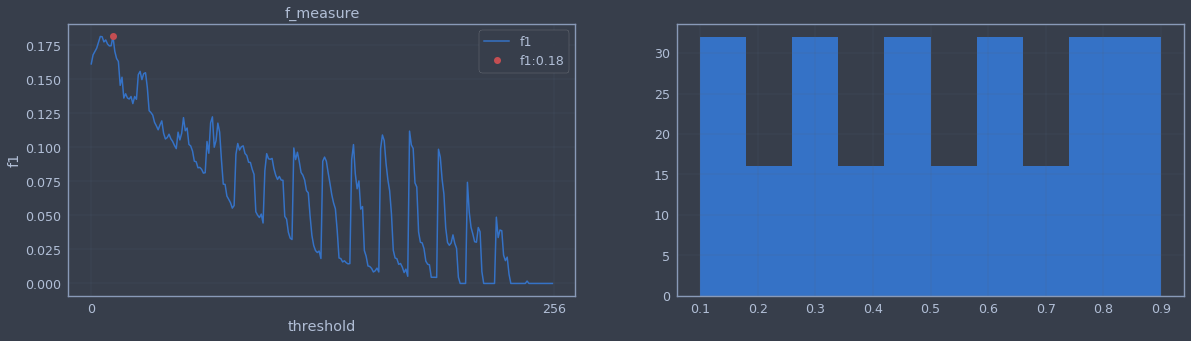

In [109]:
f1 = monitor_one(optimizer.results, "f_measure")

tested = list(optimizer.history.keys())
tested = [t[0] for t in tested]

best_combination = display_history(f1, tested, bins=10)

In [110]:
# Apply to eval
segments = encoder.encode(
    eval_strong_prediction,
    method="threshold",
    **parameters
)
to_evaluate = encoder.parse(segments, eval_filenames)
evaluator = eb_evaluator(eval_strong_y_true, to_evaluate)
print(evaluator)

Event based metrics (onset-offset)
  Evaluated length                  : 7543.56 sec
  Evaluated files                   : 880 
  Evaluate onset                    : True 
  Evaluate offset                   : True 
  T collar                          : 200.00 ms
  Offset (length)                   : 20.00 %

  Overall metrics (micro-average)
  F-measure
    F-measure (F1)                  : 26.52 %
    Precision                       : 33.14 %
    Recall                          : 22.10 %
  Error rate
    Error rate (ER)                 : 1.22 
    Substitution rate               : 0.00 
    Deletion rate                   : 0.78 
    Insertion rate                  : 0.44 

  Class-wise average metrics (macro-average)
  F-measure
    F-measure (F1)                  : 15.00 %
    Precision                       : 20.67 %
    Recall                          : 13.48 %
  Error rate
    Error rate (ER)                 : 1.60 
    Deletion rate                   : 0.87 
    Insertion rate 

## Hysteresis

In [ ]:
# Create the optimizer
optimizer = DichotomicOptimizer(
    {
        "low": (0.001, 0.9),
        "high": (0.001, 0.9),
        "smooth": "smoothMovingAvg",
        "window_len": (5, 27)
    },
    
    encoder = encoder,
    step = 6,
    nb_recurse = 10,
    nb_process = 20
)

# Perform the optimization ON TEST
optimizer.fit(
    y_true=test_strong_y_true,
    y_pred=test_strong_prediction,
    filenames=test_filenames,
    method="hysteresis",
    verbose=2
)

In [ ]:
parameters, score = optimizer.best
parameters, score

In [109]:
# detail test score
segments = encoder.encode(
    test_strong_prediction,
    method="hysteresis",
    **parameters
)
to_evaluate = encoder.parse(segments, test_filenames)
evaluator = eb_evaluator(test_strong_y_true, to_evaluate)
print(evaluator)

Event based metrics (onset-offset)
  Evaluated length                  : 2616.88 sec
  Evaluated files                   : 288 
  Evaluate onset                    : True 
  Evaluate offset                   : True 
  T collar                          : 200.00 ms
  Offset (length)                   : 20.00 %

  Overall metrics (micro-average)
  F-measure
    F-measure (F1)                  : 8.87 %
    Precision                       : 15.69 %
    Recall                          : 6.18 %
  Error rate
    Error rate (ER)                 : 1.25 
    Substitution rate               : 0.03 
    Deletion rate                   : 0.91 
    Insertion rate                  : 0.31 

  Class-wise average metrics (macro-average)
  F-measure
    F-measure (F1)                  : 17.07 %
    Precision                       : 19.53 %
    Recall                          : 16.09 %
  Error rate
    Error rate (ER)                 : 1.21 
    Deletion rate                   : 0.84 
    Insertion rate   

298 0.17069150277517886


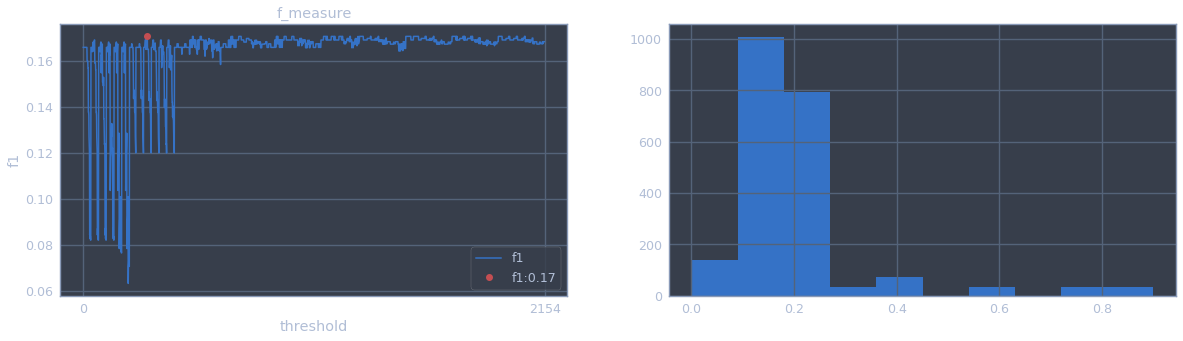

In [110]:
f1 = monitor_one(optimizer.results, "f_measure")

tested = list(optimizer.history.keys())
tested = [t[0] for t in tested]

best_combination = display_history(f1, tested, bins=10)

In [111]:
# Apply to eval
segments = encoder.encode(
    eval_strong_prediction,
    method="hysteresis",
    **parameters
)
to_evaluate = encoder.parse(segments, eval_filenames)
evaluator = eb_evaluator(eval_strong_y_true, to_evaluate)
print(evaluator)

Event based metrics (onset-offset)
  Evaluated length                  : 7543.56 sec
  Evaluated files                   : 880 
  Evaluate onset                    : True 
  Evaluate offset                   : True 
  T collar                          : 200.00 ms
  Offset (length)                   : 20.00 %

  Overall metrics (micro-average)
  F-measure
    F-measure (F1)                  : 4.76 %
    Precision                       : 8.46 %
    Recall                          : 3.31 %
  Error rate
    Error rate (ER)                 : 1.31 
    Substitution rate               : 0.02 
    Deletion rate                   : 0.95 
    Insertion rate                  : 0.34 

  Class-wise average metrics (macro-average)
  F-measure
    F-measure (F1)                  : 13.37 %
    Precision                       : 14.91 %
    Recall                          : 13.59 %
  Error rate
    Error rate (ER)                 : 1.38 
    Deletion rate                   : 0.86 
    Insertion rate    

## Derivative

In [52]:
# Create the optimizer

optimizer = DichotomicOptimizer(
    {
        "rising" : (0.01, 0.99),
        "decreasing": (-0.01, -0.99),
        "high": (0.001, 0.9),
        "smooth": "smoothMovingAvg",
        "window_len":[17, 19, 21],
        "window_size": [17, 19, 21],
    },
    
    encoder = encoder,
    step = 5,
    nb_recurse = 10,
    nb_process = 20
)

# Perform the optimization ON TEST
optimizer.fit(
    y_true=test_strong_y_true,
    y_pred=test_strong_prediction,
    filenames=test_filenames,
    method="derivative",
    verbose=2
)

PicklingError: Can't pickle <class 'sed_tool.Encoder.Encoder'>: it's not the same object as sed_tool.Encoder.Encoder

In [37]:
parameters, score = optimizer.best
parameters, score

({'rising': 0.99,
  'decreasing': -3.9599999999999995,
  'high': 0.004,
  'smooth': 'smoothMovingAvg',
  'window_len': 17,
  'window_size': 21},
 0.3205227476809085)

In [38]:
# detail test score
segments = encoder.encode(
    test_strong_prediction,
    method="hysteresis",
    **parameters
)
to_evaluate = encoder.parse(segments, test_filenames)
evaluator = eb_evaluator(test_strong_y_true, to_evaluate)
print(evaluator)

Event based metrics (onset-offset)
  Evaluated length                  : 2616.88 sec
  Evaluated files                   : 288 
  Evaluate onset                    : True 
  Evaluate offset                   : True 
  T collar                          : 200.00 ms
  Offset (length)                   : 20.00 %

  Overall metrics (micro-average)
  F-measure
    F-measure (F1)                  : 23.46 %
    Precision                       : 23.53 %
    Recall                          : 23.40 %
  Error rate
    Error rate (ER)                 : 1.49 
    Substitution rate               : 0.04 
    Deletion rate                   : 0.73 
    Insertion rate                  : 0.73 

  Class-wise average metrics (macro-average)
  F-measure
    F-measure (F1)                  : 32.05 %
    Precision                       : 34.36 %
    Recall                          : 30.99 %
  Error rate
    Error rate (ER)                 : 1.35 
    Deletion rate                   : 0.69 
    Insertion rate 

5868 0.3205227476809085


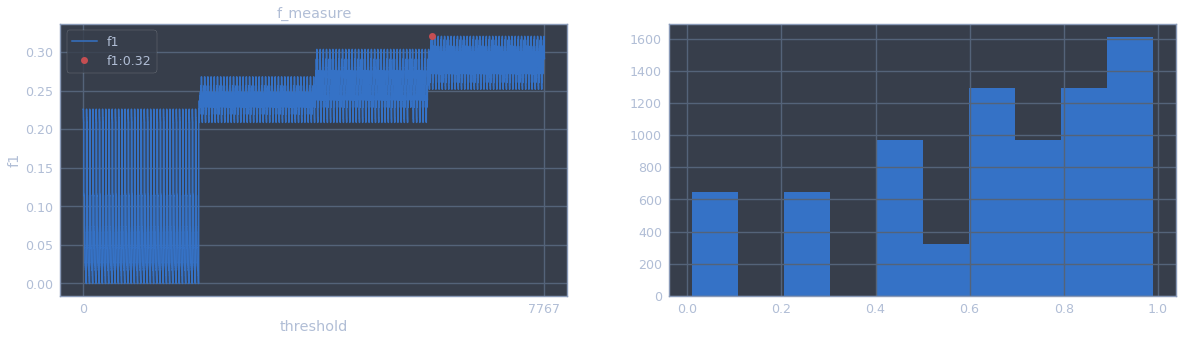

In [39]:
f1 = monitor_one(optimizer.results, "f_measure")

tested = list(optimizer.history.keys())
tested = [t[0] for t in tested]

best_combination = display_history(f1, tested, bins=10)

In [40]:
# Apply to eval
segments = encoder.encode(
    eval_strong_prediction,
    method="hysteresis",
    **parameters
)
to_evaluate = encoder.parse(segments, eval_filenames)
evaluator = eb_evaluator(eval_strong_y_true, to_evaluate)
print(evaluator)

Event based metrics (onset-offset)
  Evaluated length                  : 7543.56 sec
  Evaluated files                   : 880 
  Evaluate onset                    : True 
  Evaluate offset                   : True 
  T collar                          : 200.00 ms
  Offset (length)                   : 20.00 %

  Overall metrics (micro-average)
  F-measure
    F-measure (F1)                  : 16.39 %
    Precision                       : 16.00 %
    Recall                          : 16.82 %
  Error rate
    Error rate (ER)                 : 1.67 
    Substitution rate               : 0.05 
    Deletion rate                   : 0.79 
    Insertion rate                  : 0.84 

  Class-wise average metrics (macro-average)
  F-measure
    F-measure (F1)                  : 23.93 %
    Precision                       : 23.55 %
    Recall                          : 25.86 %
  Error rate
    Error rate (ER)                 : 1.63 
    Deletion rate                   : 0.74 
    Insertion rate 